### Collaborative filtering recommendations

1. Import bibliotek

In [52]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import psycopg2
from sqlalchemy import create_engine, text

2. Wczytanie danych

In [7]:
# Connect to PostgreSQL server
host= "localhost"
database="movierecommenderdb"
user= "postgres"
password= "postgres"
port= "5432"


alchemyEngine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')
 
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect()

# Read data from PostgreSQL database table and load into a DataFrame instance
query_movies = text('SELECT * FROM "Movies"')
query_ratings = text('SELECT * FROM "Ratings"')
df_movie = pd.read_sql_query(query_movies, dbConnection)

chunk_size = 10000  # Adjust as needed
proccessed_data = pd.DataFrame()  # Initialize empty dataframe
for chunk in pd.read_sql_query(query_ratings, dbConnection, chunksize=chunk_size):
    # Process the chunk
    proccessed_data = proccessed_data.append(chunk)


#df_rating = pd.read_sql_query(query_ratings, dbConnection)

pd.set_option('display.expand_frame_repr', False)

# Close the database connectiona
dbConnection.close()

C:\Users\dabro\AppData\Local\Temp\ipykernel_17812\1400881589.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  proccessed_data = proccessed_data.append(chunk)
C:\Users\dabro\AppData\Local\Temp\ipykernel_17812\1400881589.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  proccessed_data = proccessed_data.append(chunk)
C:\Users\dabro\AppData\Local\Temp\ipykernel_17812\1400881589.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  proccessed_data = proccessed_data.append(chunk)
C:\Users\dabro\AppData\Local\Temp\ipykernel_17812\1400881589.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  proccessed_data = proccessed_data.append(chu

MemoryError: Unable to allocate 5.19 MiB for an array with shape (1, 680000) and data type float64

In [5]:
df_movie = df_movie[['id', 'title']]
df_movie.head()

C:\Users\aldabrow\AppData\Local\Temp\ipykernel_15548\3866755971.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_movie = pd.read_csv(path+ "movies_metadata.csv",  engine='python' , encoding='utf8', error_bad_lines=False)


,movieId,title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [7]:
df_rating = df_rating.drop(columns=['timestamp'])
df_rating.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


3. Przygotowanie i czyszczenie danych

In [10]:
df_movie.shape

(42278, 2)

In [11]:
df_rating.shape

(26024289, 3)

In [12]:
#merge the two dataframes on the movieId column and id column
df_movie_rating = pd.merge(df_movie, df_rating, on='movieId')
df_movie_rating.head()

,movieId,title,userId,rating
0,862,Toy Story,1923,3.0
1,862,Toy Story,2103,5.0
2,862,Toy Story,5380,1.0
3,862,Toy Story,6177,4.0
4,862,Toy Story,6525,4.0


In [13]:
df_movie_rating.shape

(10875847, 4)

Normalizacja ratingu do przedziału [0,1]

In [16]:
#scale the rating column to be between 0 and 1
min_rating = df_movie_rating['rating'].min()
max_rating = df_movie_rating['rating'].max()

# Normalize ratings to the range [0, 1]
df_movie_rating['normalized_rating'] = (df_movie_rating['rating'] - min_rating) / (max_rating - min_rating)
df_movie_rating.head()

,movieId,title,userId,rating,normalized_rating
1,862,Toy Story,2103,5.0,1.000000
2,862,Toy Story,5380,1.0,0.111111
4,862,Toy Story,6525,4.0,0.777778
5,862,Toy Story,7050,3.0,0.555556
6,862,Toy Story,7238,3.0,0.555556


4. EDA

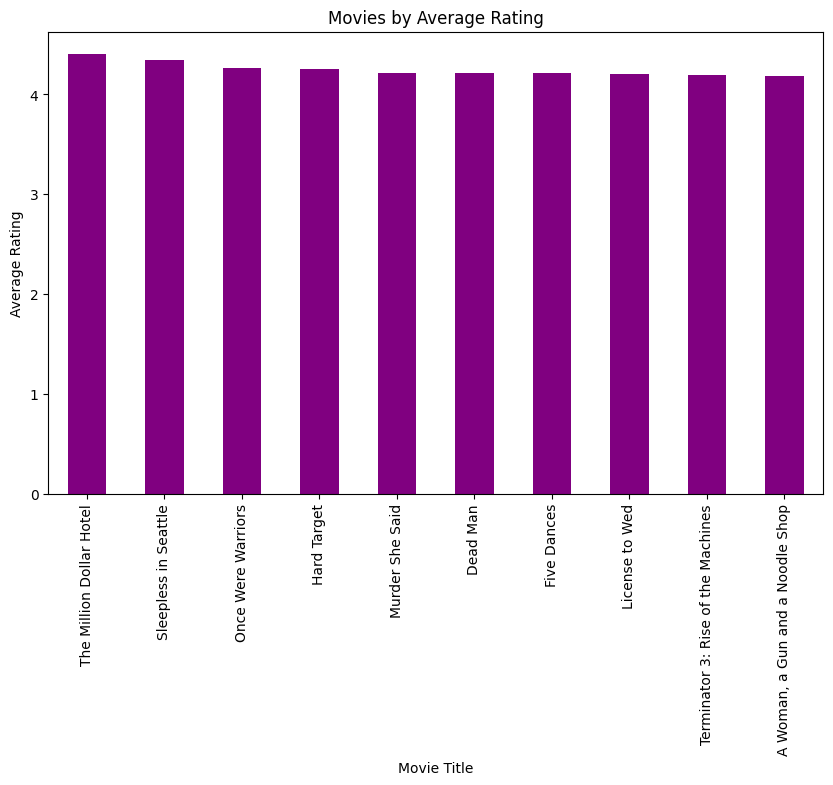

In [17]:
#movies by average rating
avarage_rating = df_movie_rating.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
avarage_rating.plot(kind='bar', color = 'purple')
plt.title('Movies by Average Rating')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.show()


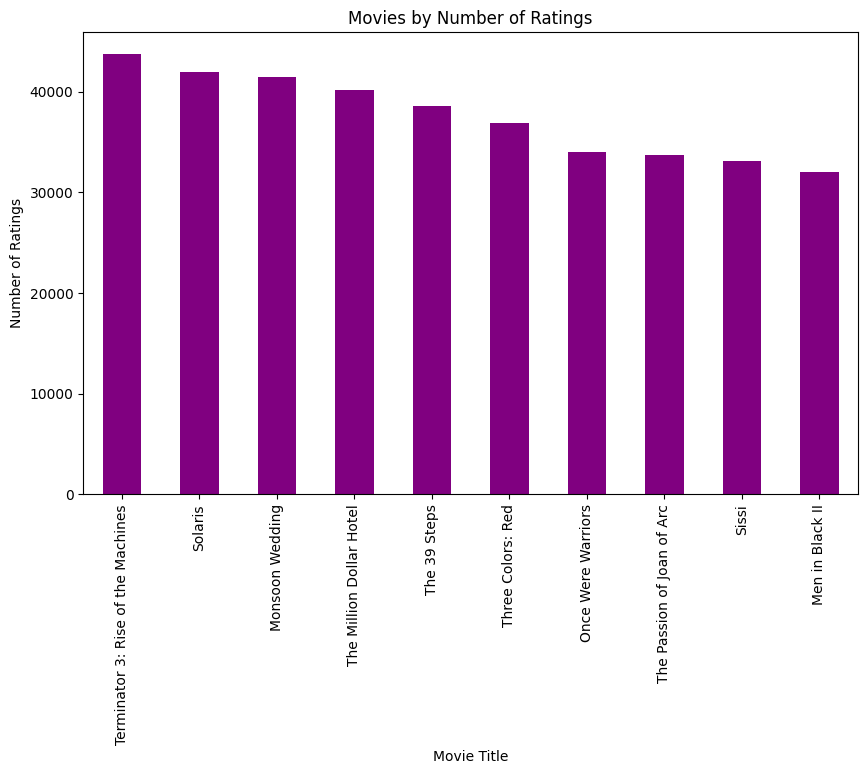

In [19]:
#movies by number of ratings
number_of_ratings = df_movie_rating.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
number_of_ratings.plot(kind='bar', color = 'purple')
plt.title('Movies by Number of Ratings')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.show()

5. Tabela przestawna item-user

In [20]:
#pivot the dataframe to get the movie titles as the columns and the userId as the rows and the ratings as the values
df_movie_rating_pivot = df_movie_rating.pivot_table(index='movieId', columns='userId', values='normalized_rating')
df_movie_rating_pivot.head()

userId,11,12,15,16,20,24,34,37,41,43,...,270860,270869,270871,270872,270879,270885,270887,270893,270894,270896
movieId,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,0.555556,0.555556,NaN,NaN,0.777778,...,0.555556,0.333333,0.444444,NaN,0.666667,NaN,1.000000,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.777778,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,0.777778,NaN,NaN,0.777778,0.777778,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.555556,NaN,NaN,NaN,NaN,NaN,0.777778,NaN,NaN,0.666667


In [21]:
df_movie_rating_pivot.shape

(2798, 58865)

In [22]:
#fill the null values with 0
df_movie_rating_pivot = df_movie_rating_pivot.fillna(0)
df_movie_rating_pivot.head()

userId,11,12,15,16,20,24,34,37,41,43,...,270860,270869,270871,270872,270879,270885,270887,270893,270894,270896
movieId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.000000,0.0,0.0,0.555556,0.555556,0.0,0.0,0.777778,...,0.555556,0.333333,0.444444,0.0,0.666667,0.0,1.000000,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.777778,0.0,0.0,0.000000
5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
6,0.0,0.0,0.777778,0.0,0.0,0.777778,0.777778,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.0,0.000000
11,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.555556,0.000000,0.000000,0.0,0.000000,0.0,0.777778,0.0,0.0,0.666667


6. Miara podobieństwa

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
movie_similarity = cosine_similarity(df_movie_rating_pivot)
movie_similarity.shape

(2798, 2798)

In [24]:
similar_movies_df = pd.DataFrame(movie_similarity, index=df_movie_rating_pivot.index, columns=df_movie_rating_pivot.index)
similar_movies_df.head()

movieId,2,3,5,6,11,12,13,14,15,16,...,143355,148652,155288,158238,160718,163937,166643,167738,168712,169864
movieId,,,,,,,,,,,,,,,,,,,,,
2,1.000000,0.304228,0.327931,0.334642,0.357365,0.180695,0.187552,0.147139,0.230706,0.321199,...,0.083994,0.059543,0.049234,0.117645,0.087838,0.036938,0.088209,0.042229,0.040580,0.065519
3,0.304228,1.000000,0.425075,0.267412,0.342126,0.229121,0.095901,0.204646,0.188641,0.251156,...,0.030031,0.023124,0.021924,0.029018,0.021464,0.019422,0.035384,0.019342,0.014318,0.019644
5,0.327931,0.425075,1.000000,0.230304,0.365222,0.210689,0.115765,0.192010,0.175227,0.211351,...,0.034870,0.022852,0.027600,0.033706,0.028281,0.019567,0.045224,0.020283,0.024837,0.020380
6,0.334642,0.267412,0.230304,1.000000,0.323423,0.147694,0.062051,0.252883,0.176410,0.560114,...,0.055542,0.027514,0.058805,0.115911,0.042423,0.027403,0.060868,0.030635,0.015889,0.050066
11,0.357365,0.342126,0.365222,0.323423,1.000000,0.116209,0.105963,0.247377,0.190950,0.316140,...,0.035623,0.012772,0.035531,0.029978,0.021872,0.008843,0.053094,0.011029,0.009896,0.017081


7. Rekomendacje

In [25]:
def get_movie_recommendations(movie_name, top_n=30):
    target_movie = df_movie[df_movie['title'] == movie_name]
    #print(target_movie)
    if not target_movie.empty:
        target_movie_id = target_movie['movieId'].values[0]
        #print(target_movie_id)
        similar_movies = similar_movies_df[target_movie_id].sort_values(ascending=False)
        #print(similar_movies)
        similar_movies = similar_movies.drop(target_movie_id)  # Remove the target movie
        #print(similar_movies)
        top_similar_movies = similar_movies.head(top_n)
        #print(top_similar_movies)   
        
        recommendations_df = pd.DataFrame({
            'title': df_movie['title'].loc[top_similar_movies.index],
            'similarity_score': top_similar_movies.values
        })
        
        # Reset the index to make 'movieId' a regular column
        recommendations_df.reset_index(inplace=True)
        
        return recommendations_df
    else:
        return "Movie not found in the dataset."

In [26]:
movie_name = "Toy Story"
recommendations = get_movie_recommendations(movie_name)
print("Recommended Movies for", movie_name)
recommendations

Recommended Movies for Toy Story


,movieId,title,similarity_score
0,1392,Gridlock'd,0.168421
1,630,Girl 6,0.168062
2,803,The Convent,0.159028
3,55,Kids of the Round Table,0.153521
4,860,Talk of Angels,0.152857
5,764,The Cable Guy,0.149523
6,67,French Twist,0.145999
7,523,The Scout,0.143641
8,562,Bhaji on the Beach,0.143615
9,80,Things to Do in Denver When You're Dead,0.140752


8. Algorytm najbliższego sąsiedztwa

In [27]:
#apply k nearest neighbors to find the most similar movies
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute', n_jobs=-1)
knn.fit(similar_movies_df)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [28]:
def get_knn_movie_recommendations(movie_name, top_n=30):
    target_movie = df_movie[df_movie['title'] == movie_name]
    #print(target_movie)
    if not target_movie.empty:
        target_movie_id = target_movie['movieId'].values[0]
        #print(target_movie_id)
        distances, indices = knn.kneighbors([similar_movies_df[target_movie_id]], n_neighbors=top_n + 1)
        #print(distances)
        #print(indices)
        recommended_movie_indices = indices[0][1:]
        
        recommendations_df = pd.DataFrame({
            'title': df_movie['title'].loc[recommended_movie_indices],
            'similarity_score': distances[0][1:]
        })
        # Sort the DataFrame by similarity score in descending order
        recommendations_df = recommendations_df.sort_values(by='similarity_score', ascending=False)
        # Reset the index to make 'movieId' a regular column
        recommendations_df.reset_index(inplace=True)
        
        return recommendations_df[['title', 'similarity_score']].head(top_n)
    else:
        return "Movie not found in the dataset."
    

In [29]:
movie_name = "Toy Story"
recommendations = get_knn_movie_recommendations(movie_name)
print("Recommended Movies for", movie_name)
recommendations

Recommended Movies for Toy Story


,title,similarity_score
0,The Great Escape,0.157316
1,The Secret Adventures of Tom Thumb,0.156693
2,Three Lives and Only One Death,0.154399
3,Terminal Velocity,0.154360
4,Chain Reaction,0.153832
5,Notorious,0.153538
6,Bad Boys,0.152005
7,Backbeat,0.150988
8,Only You,0.149012
9,Philadelphia,0.148358
